In [5]:
## if colab 
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/Capstone/Data

Mounted at /content/drive
/content/drive/MyDrive/Capstone/Data


#### Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow import keras

### Global

In [2]:
dic_country = \
{'AUS': 'Australia',
 'BRA': 'Brazil',
 'CAN': 'India',
 'CHN': 'China',
 'GBR': 'United Kingdom',
 'IND': 'India',
 'JPN': 'Japan',
 'SGP': 'Singapore',
 'USA': 'United States'}
pd.DataFrame(dic_country,index=[0]).T.reset_index().rename(columns = {'index': 'country_code', 0: 'country_name'})

,country_code,country_name
0,AUS,Australia
1,BRA,Brazil
2,CAN,India
3,CHN,China
4,GBR,United Kingdom
5,IND,India
6,JPN,Japan
7,SGP,Singapore
8,USA,United States


### Data

Use (country_code, imputation_method) to store corresponding df
- m_dfs: manufacturing data
- s_dfs: service data

In [4]:
Data_dic_m = pd.ExcelFile('cleaned/Manufacturing_all.xlsx')
Data_dic_s = pd.ExcelFile('cleaned/Service_all.xlsx')

In [5]:
m_dfs = {}
for i in range(len(Data_dic_m.sheet_names)):
    sheet = Data_dic_m.sheet_names[i]
    df = pd.read_excel(Data_dic_m, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    m_dfs[sheet[:3]] = df

In [6]:
s_dfs = {}
for i in range(len(Data_dic_s.sheet_names)):
    sheet = Data_dic_s.sheet_names[i]
    df = pd.read_excel(Data_dic_s, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    s_dfs[sheet[:3]] = df

In [7]:
def clean_nan(data, target = 'Manufacturing_value added_%_of_GDP'):
    data = data.replace('..', np.nan)
    # drop all column 0
    data = data.dropna(axis=1, how='all')
    # drop nan row according to target
    data = data[data[target].notna()]
    return data.fillna(data.median())

#### pairwise scatterplot

##### Manufacturing

In [8]:
def make_pairwise_plot(country = 'CHN', df = None, name = 'Manufacture_GDP%', num = 4):
    data = df[country].replace('..', np.nan)
    subdata = data.dropna(axis=1, how='all')
    g = sns.FacetGrid(pd.DataFrame(list(subdata.columns[:-1])), col=0, col_wrap=num, sharex=False, height=2.6, aspect=1.7)
    for ax, x_var in zip(g.axes, list(subdata.columns[:-1])):
        subdata = subdata.rename(columns={subdata.columns[-1]: name})
        y = [subdata.columns[-1]]
        x = [x_var]
        sns.scatterplot(data = subdata[x+y].dropna(), x=x[0], y=y[0], ax=ax, hue=y[0], palette="coolwarm", legend=False)
    g.tight_layout()
    g.fig.subplots_adjust(top=0.92)
    g.fig.suptitle(dic_country[country] + ' : ' + name + ' v.s. other variables',fontsize=16, weight='bold')
    return g

/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

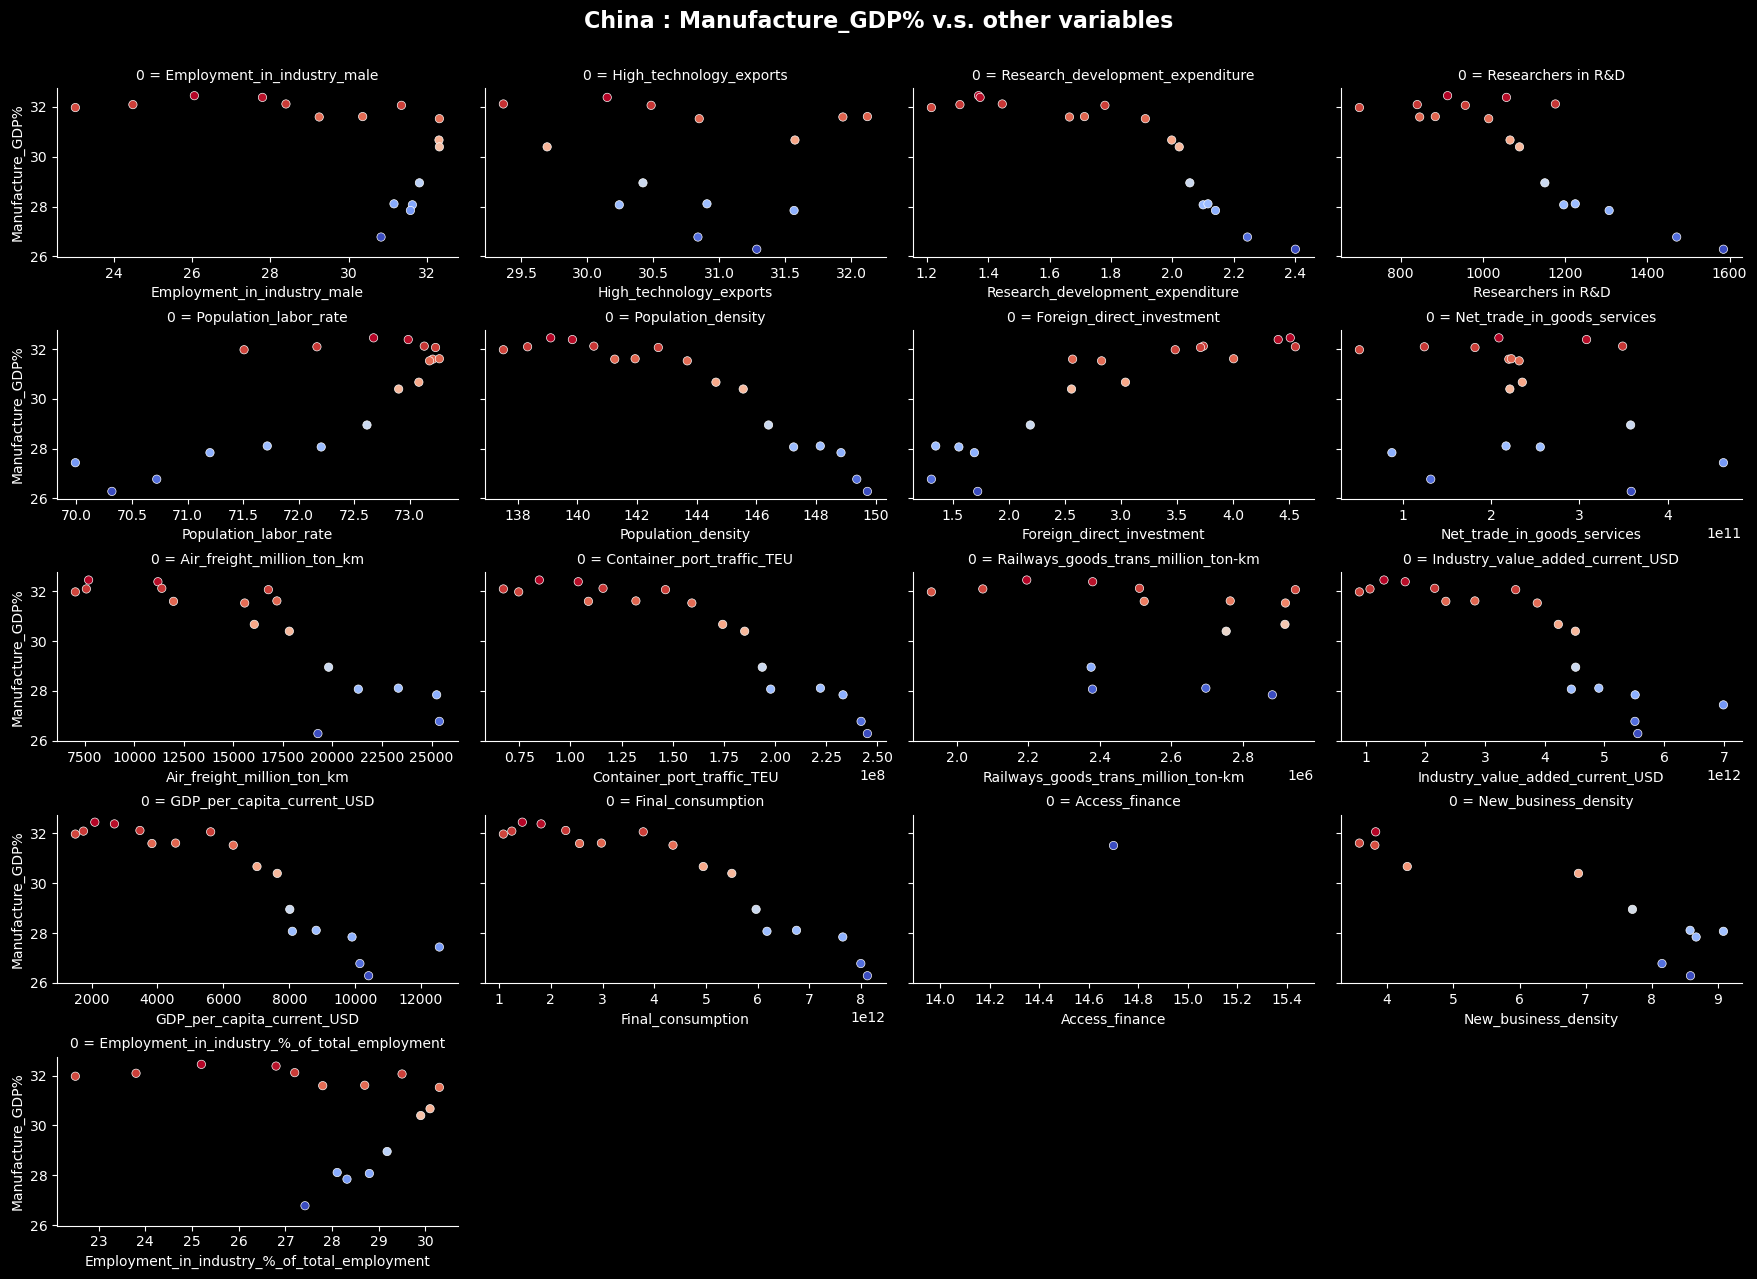

In [9]:
make_pairwise_plot('CHN',df=m_dfs)
plt.show()

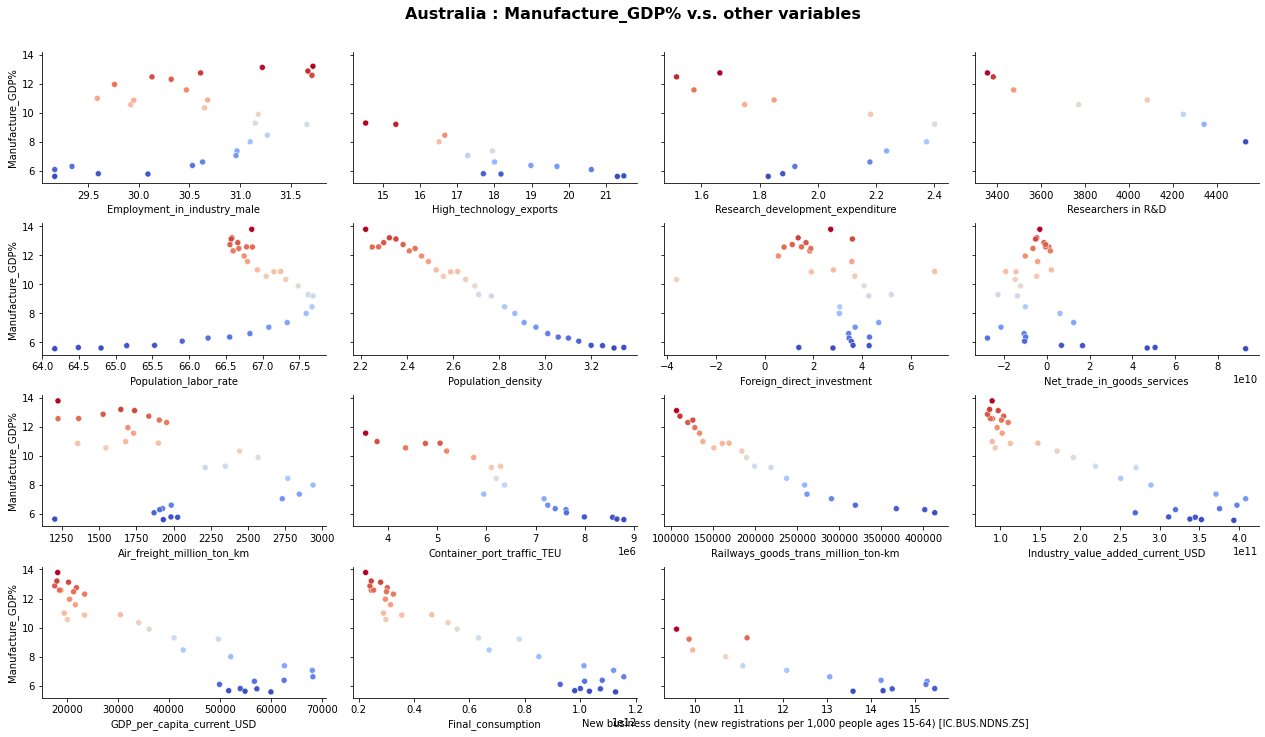

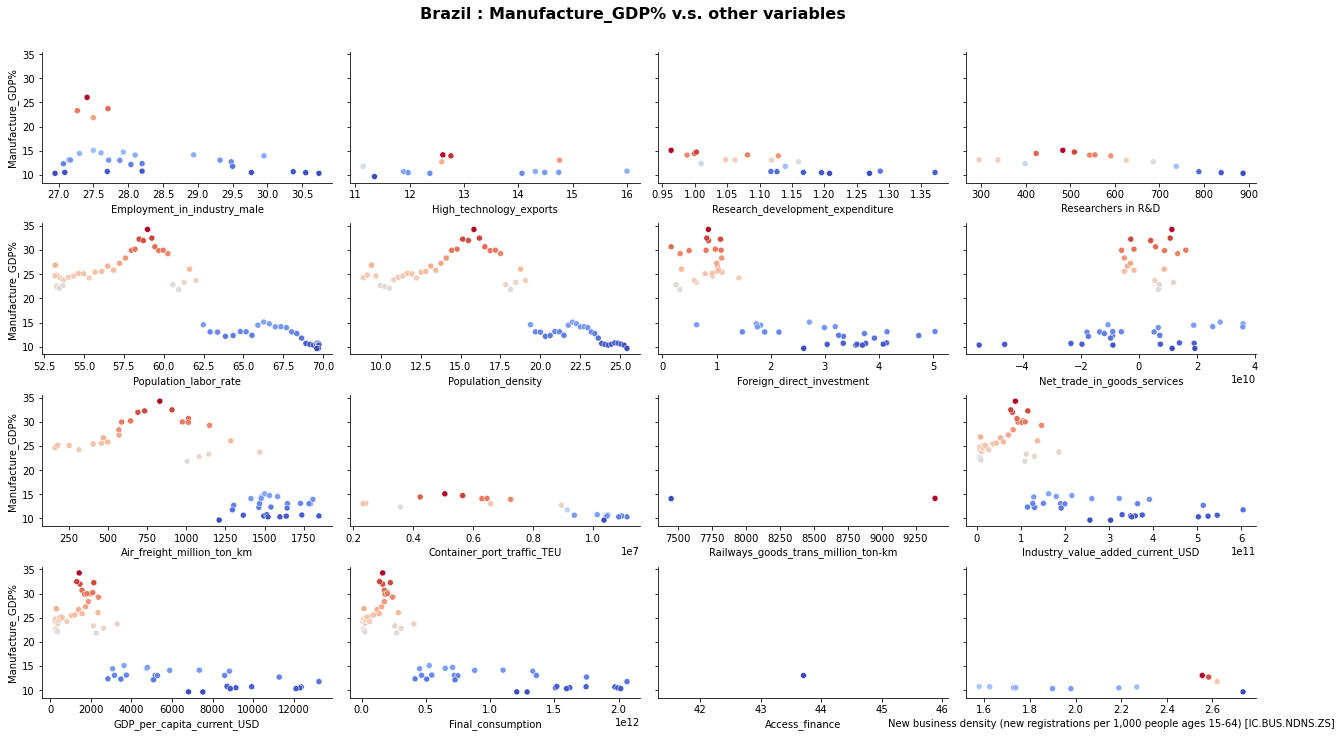

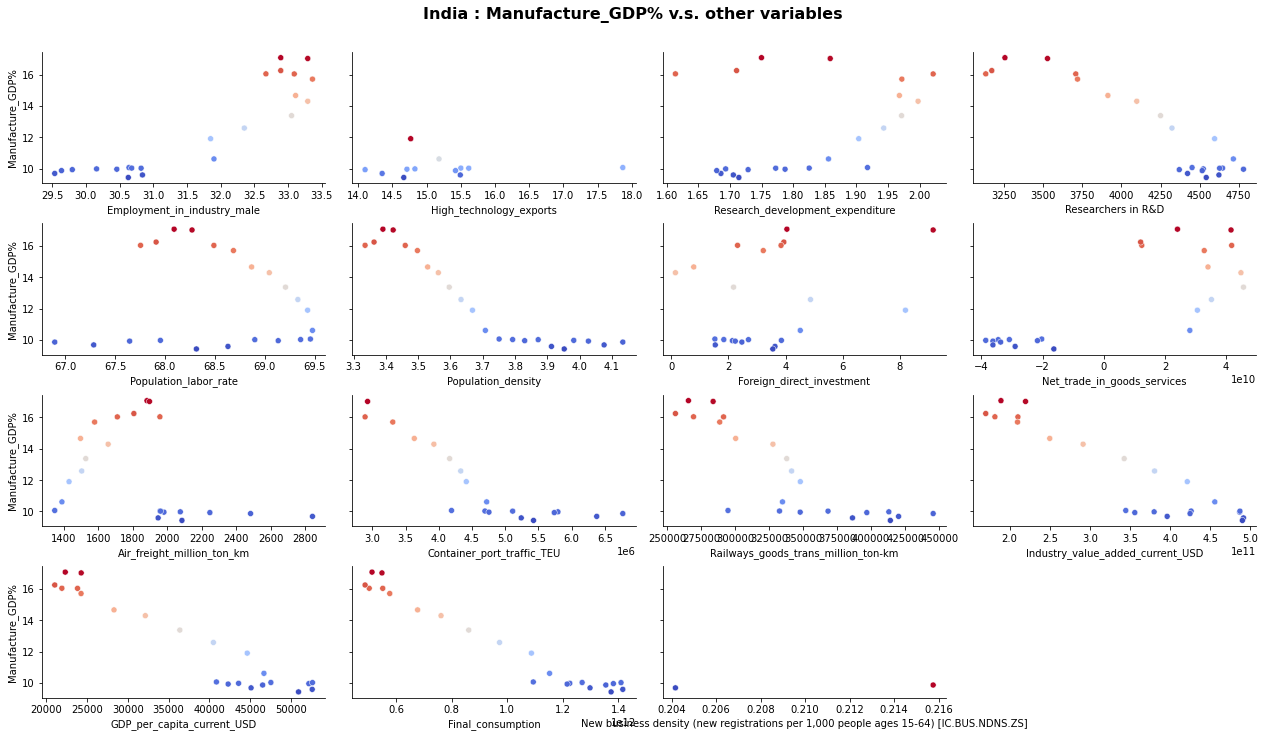

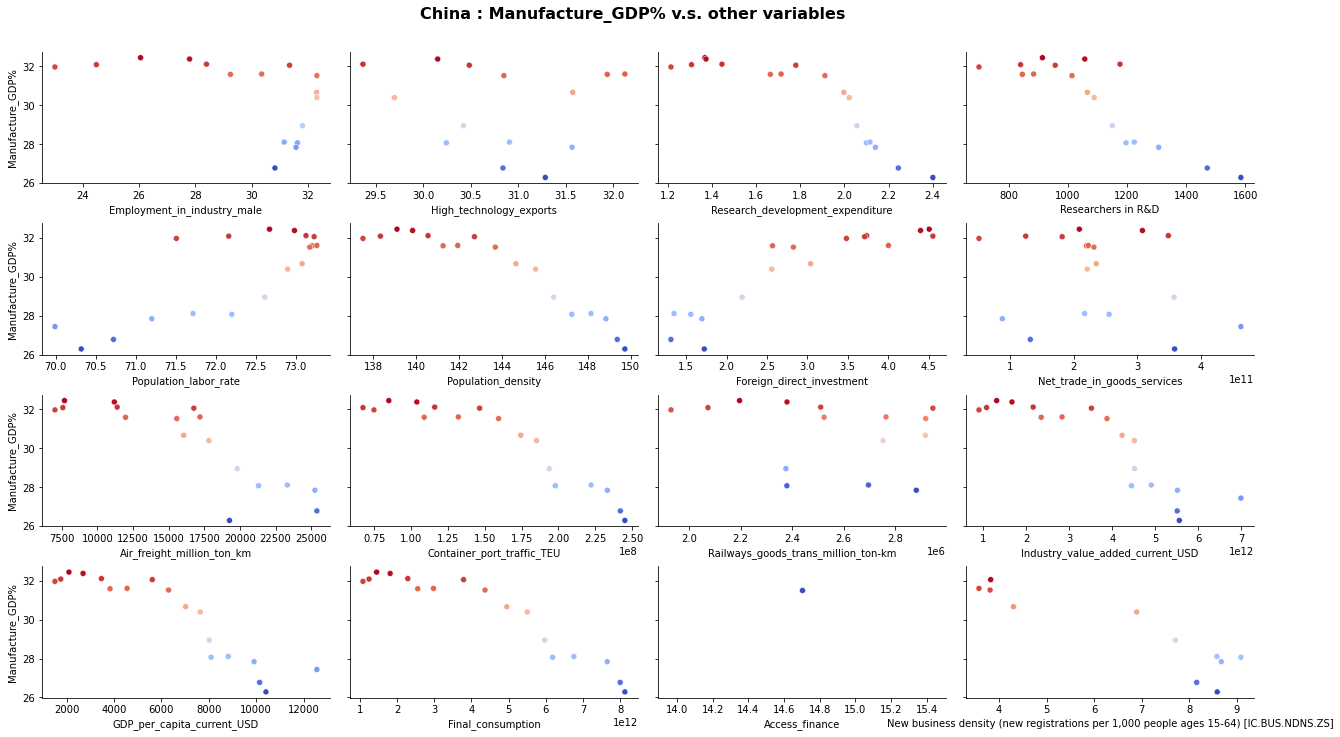

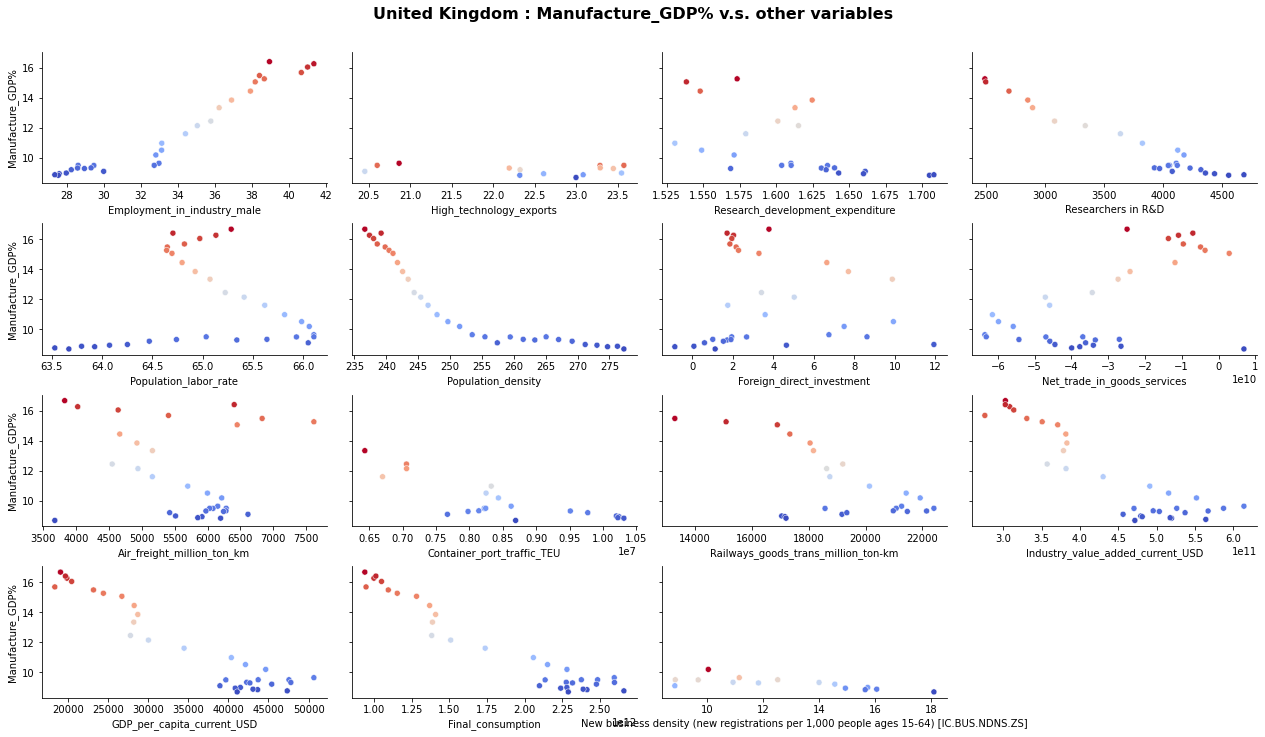

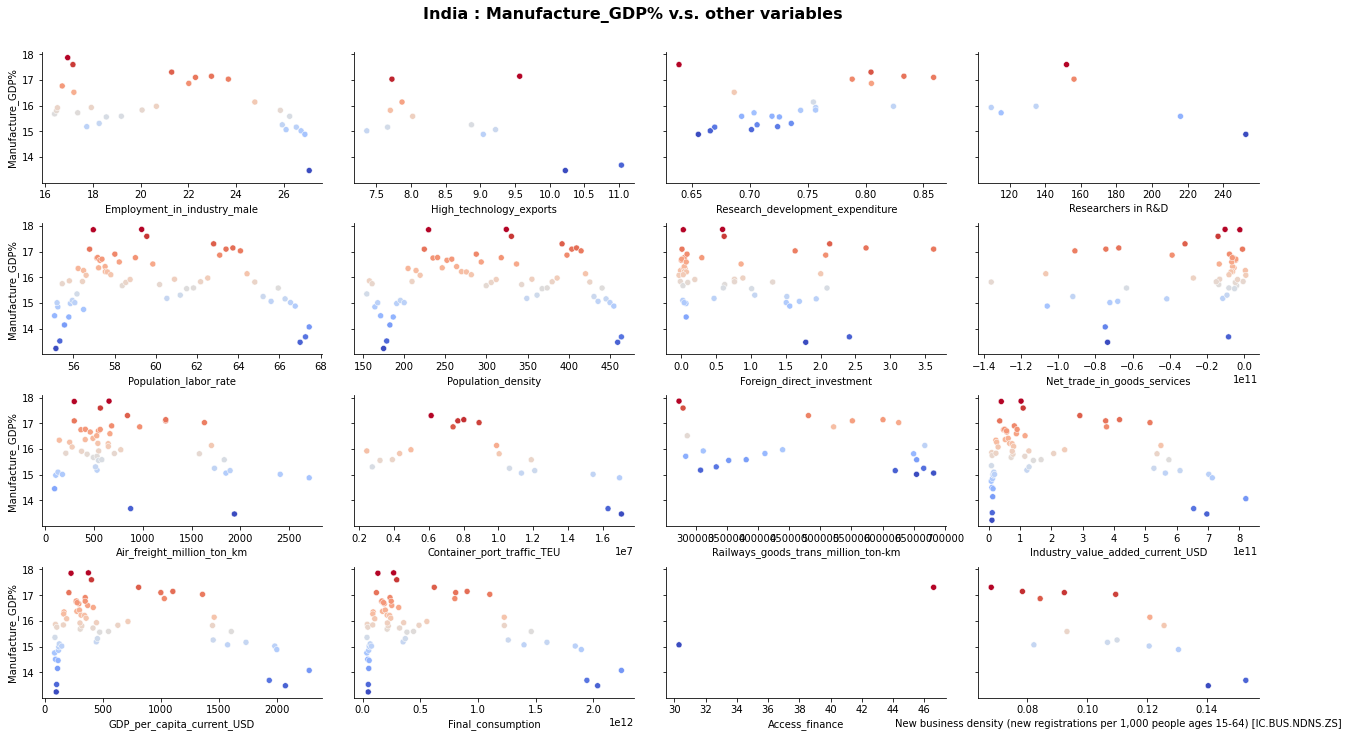

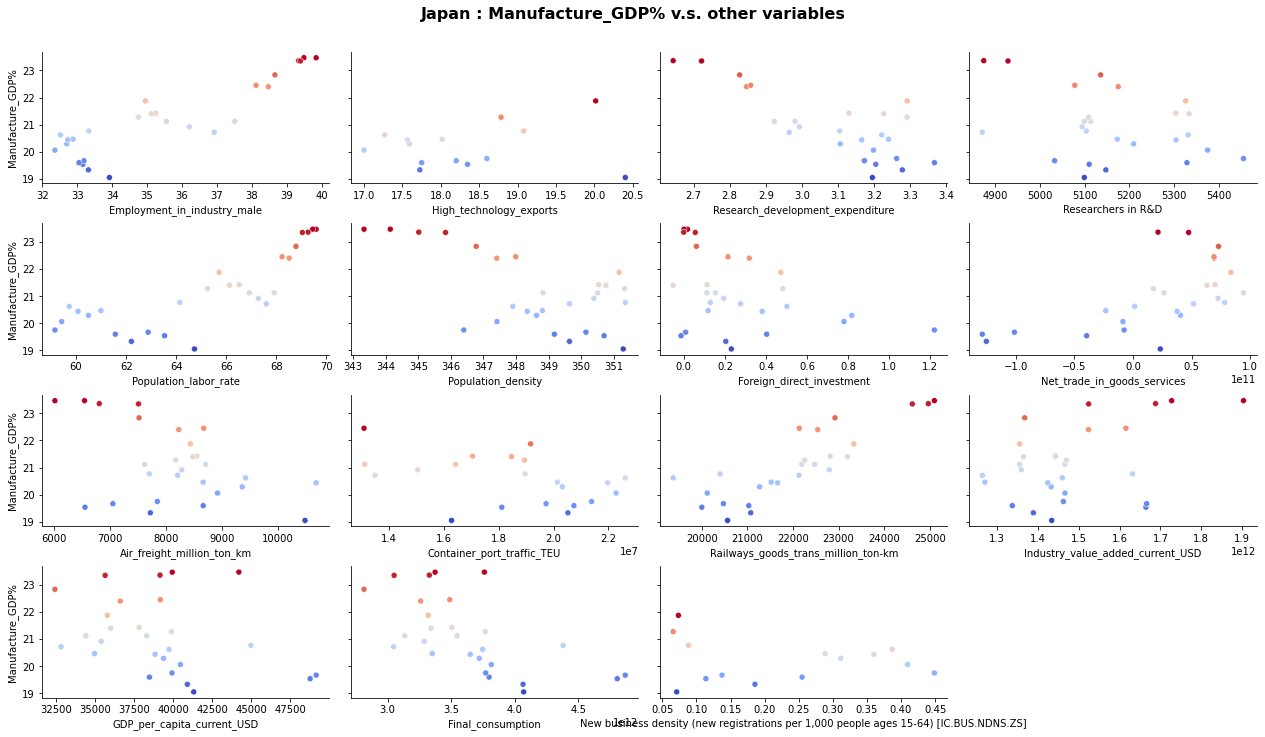

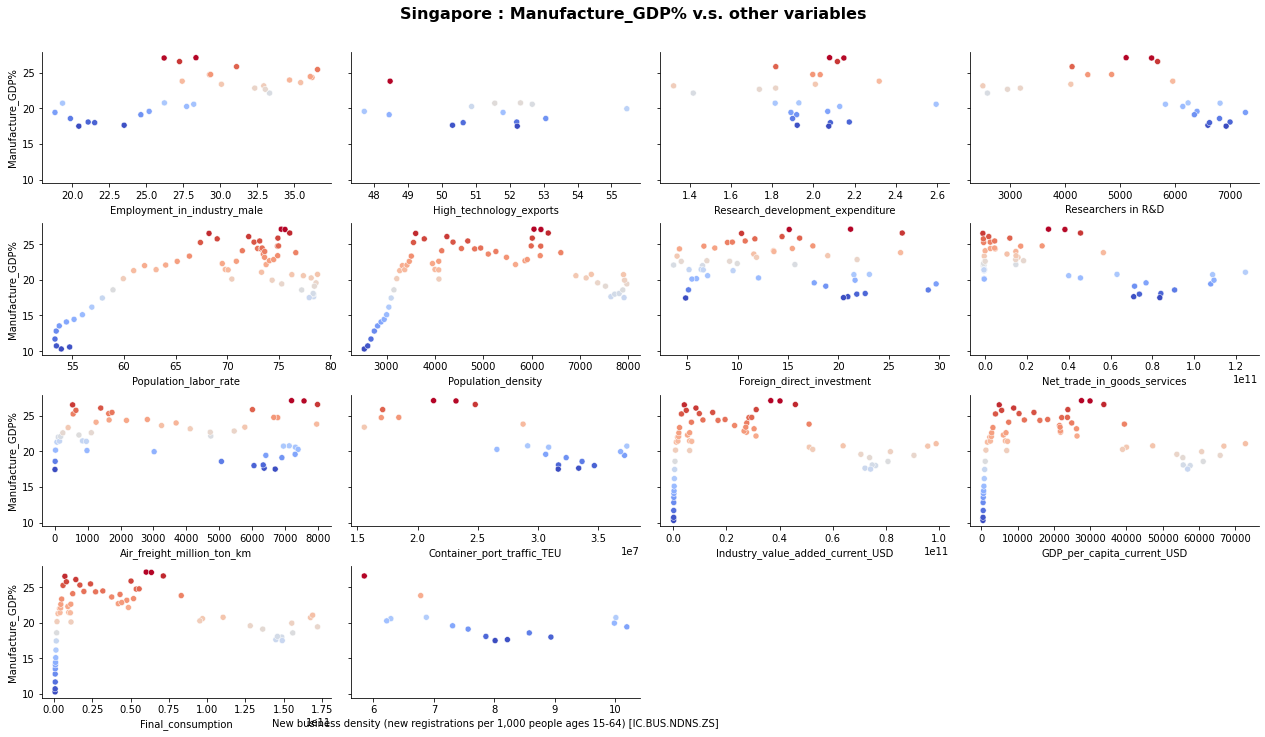

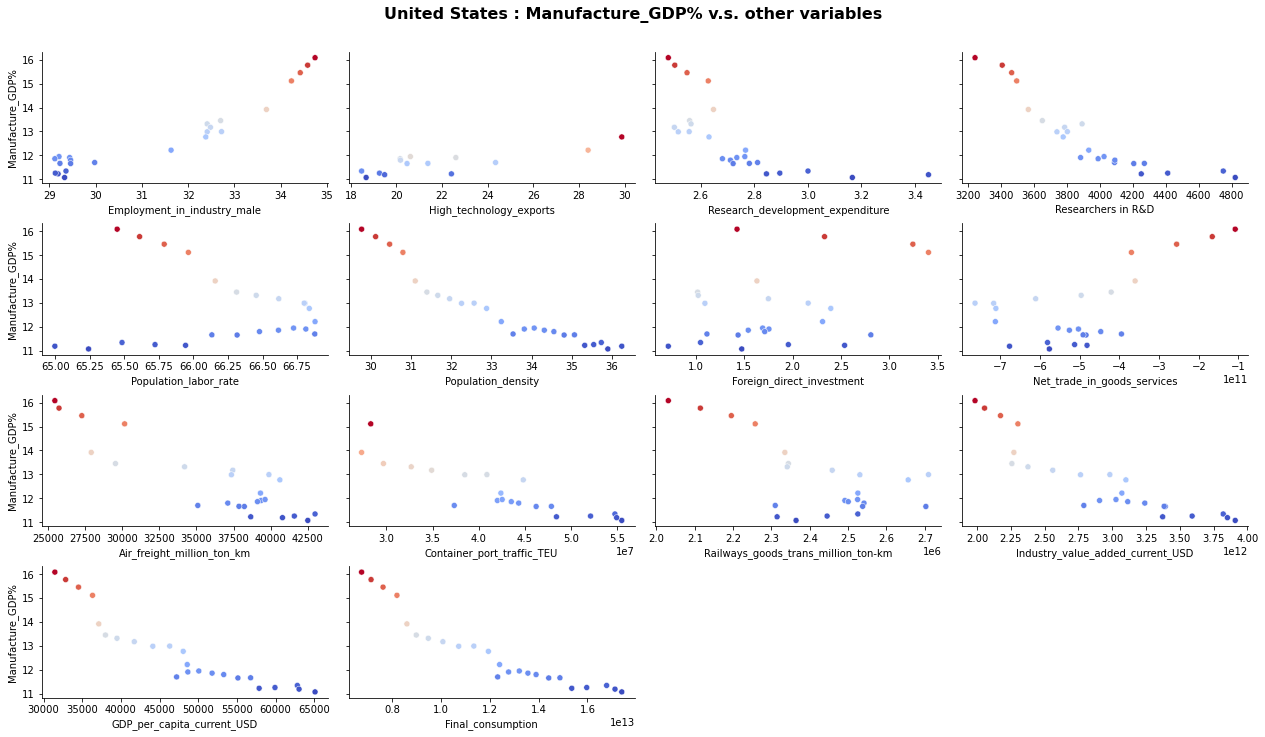

In [ ]:
for country in m_dfs.keys():
    make_pairwise_plot(country,df=m_dfs, num=4)

##### Service

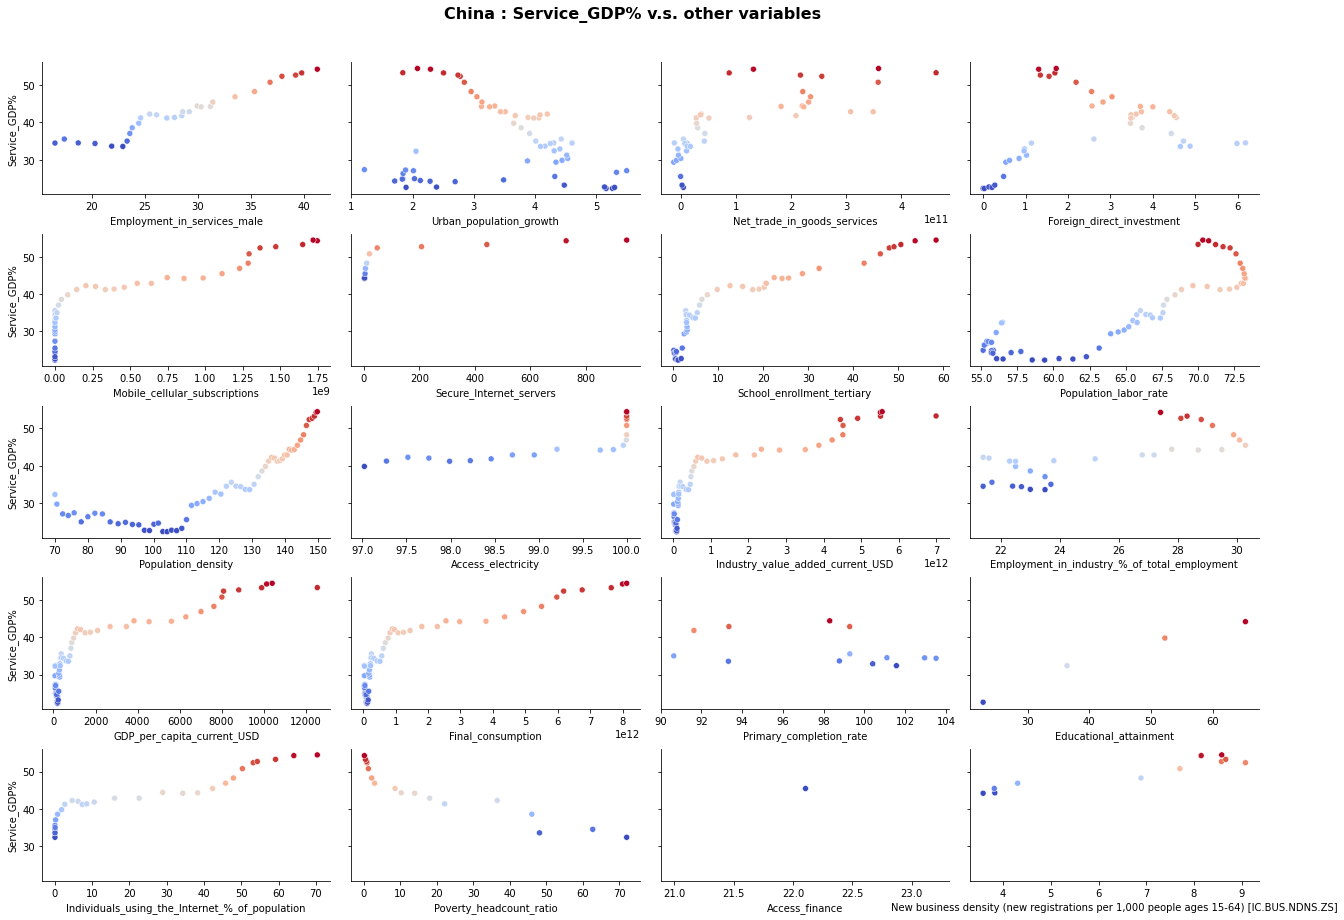

In [ ]:
make_pairwise_plot(country = 'CHN',df = s_dfs, name = 'Service_GDP%', num=4)
plt.show()

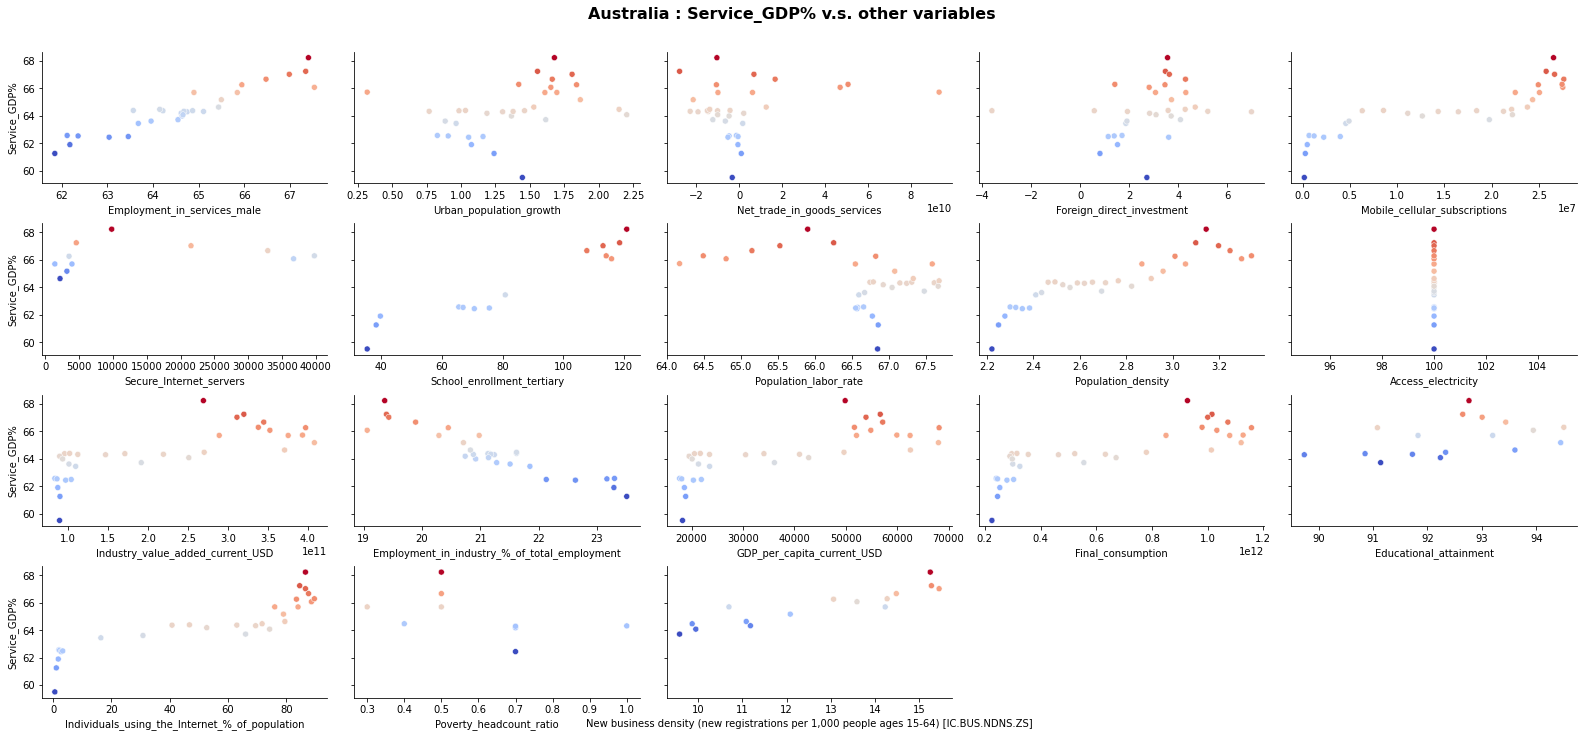

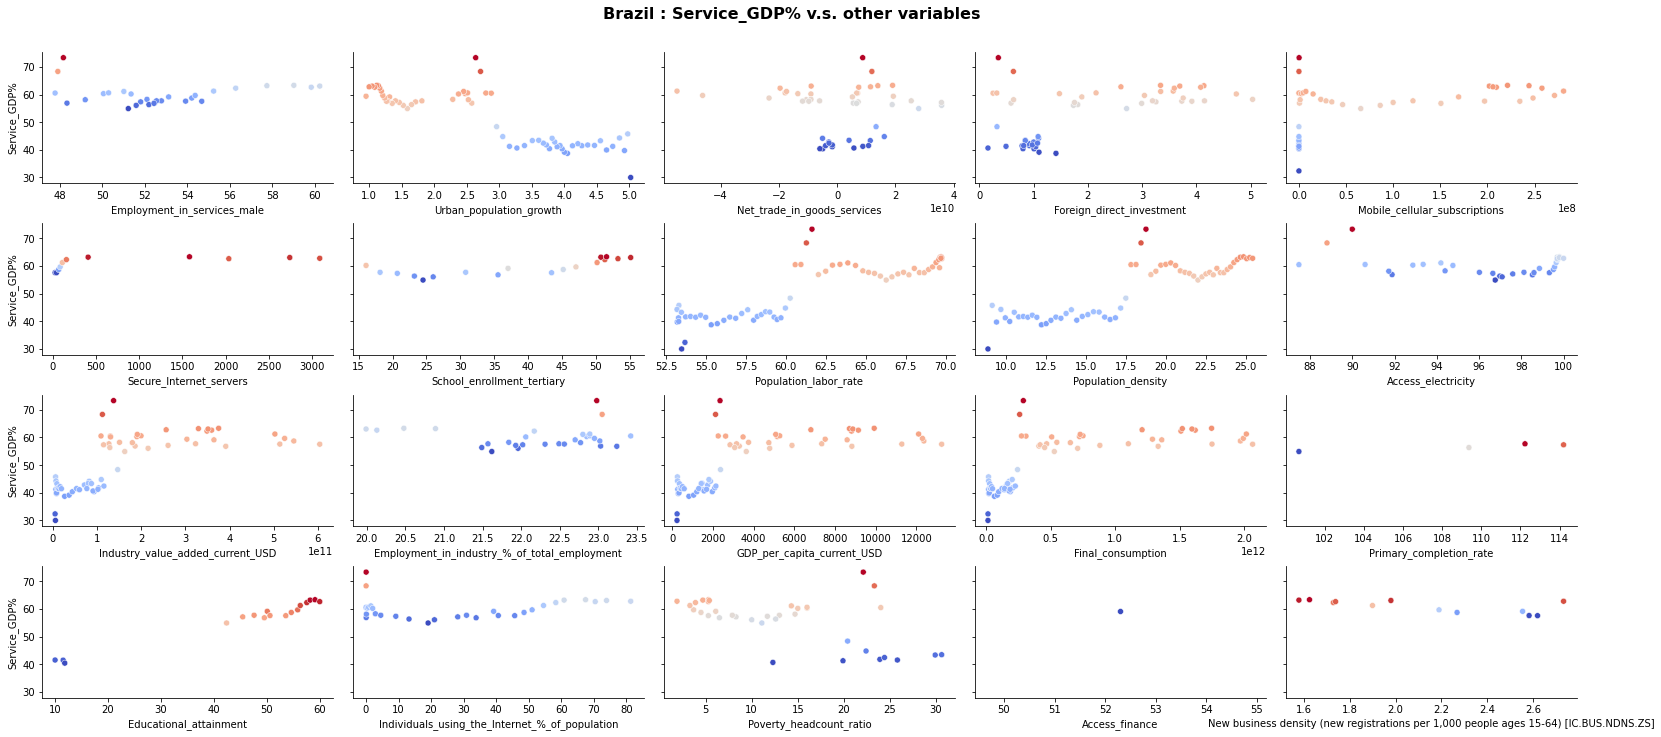

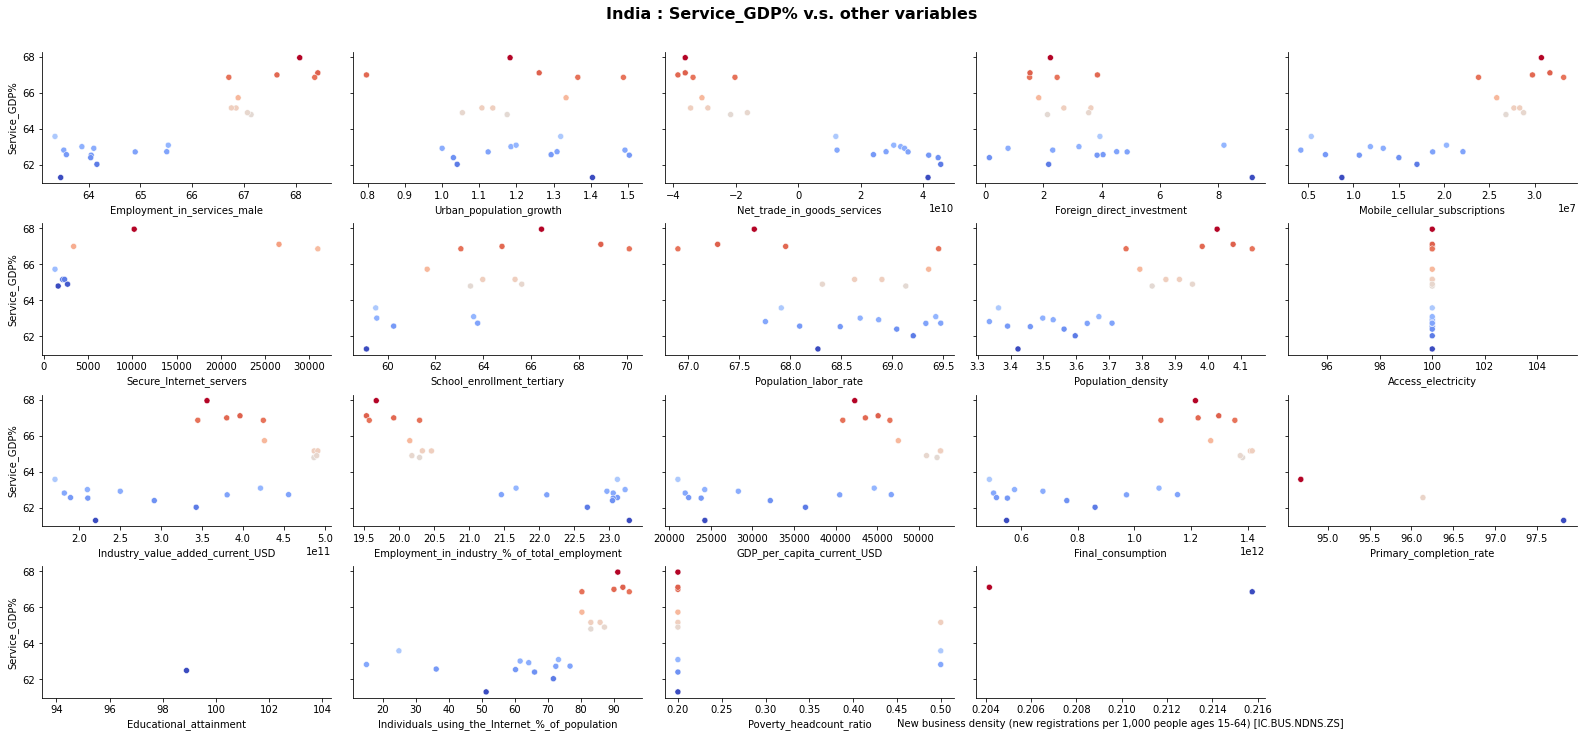

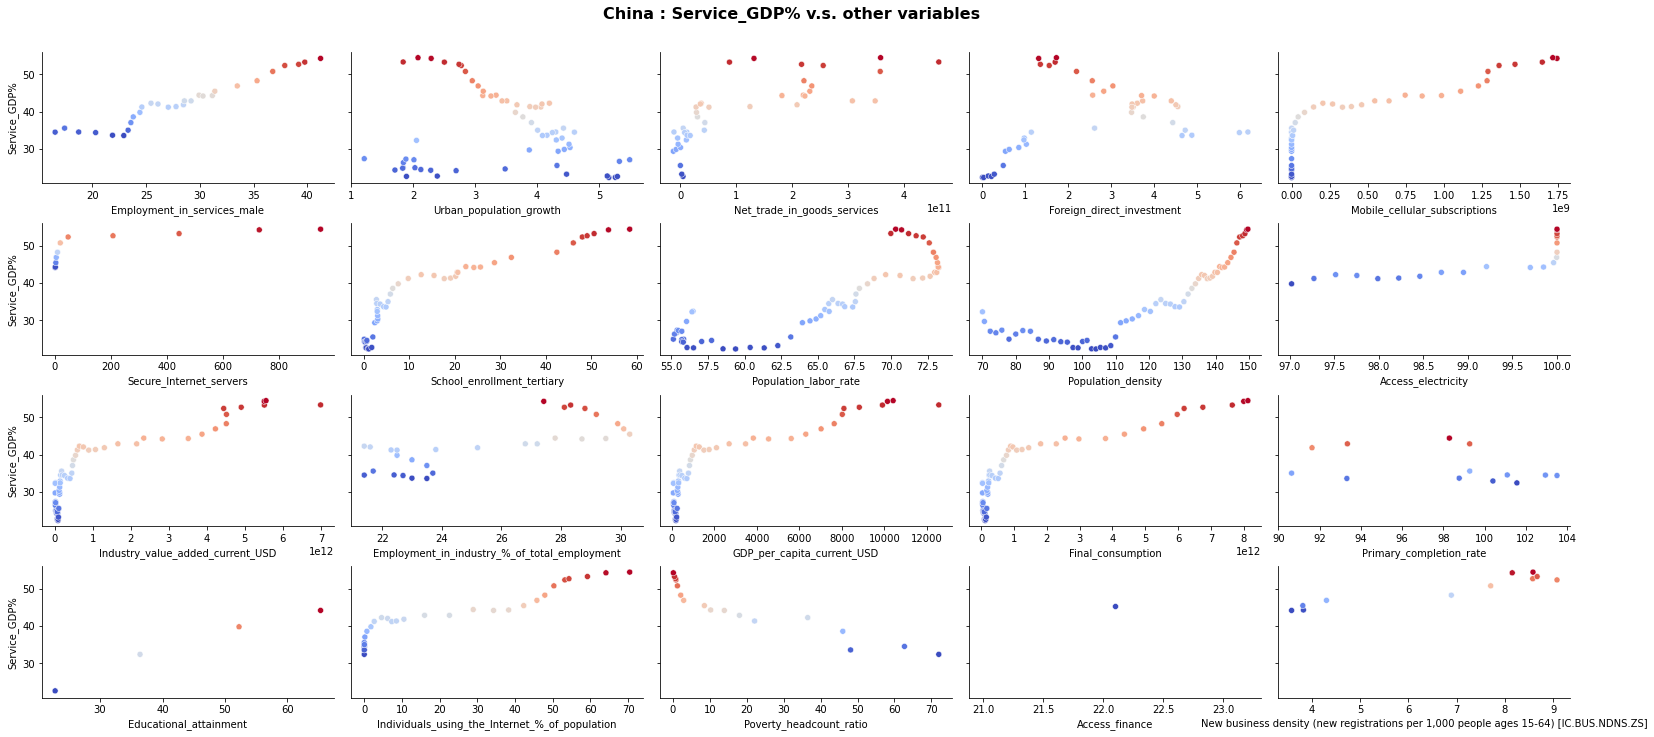

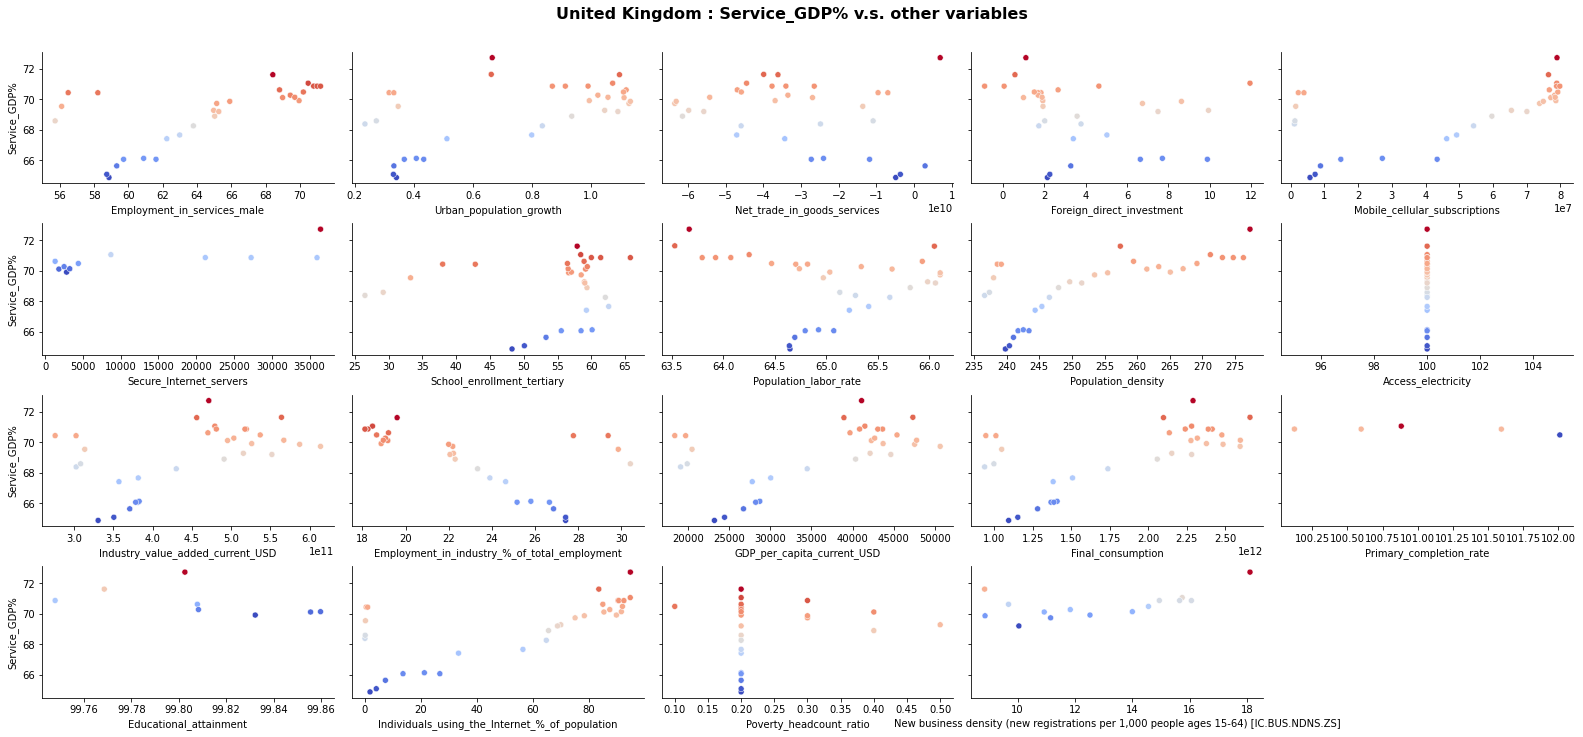

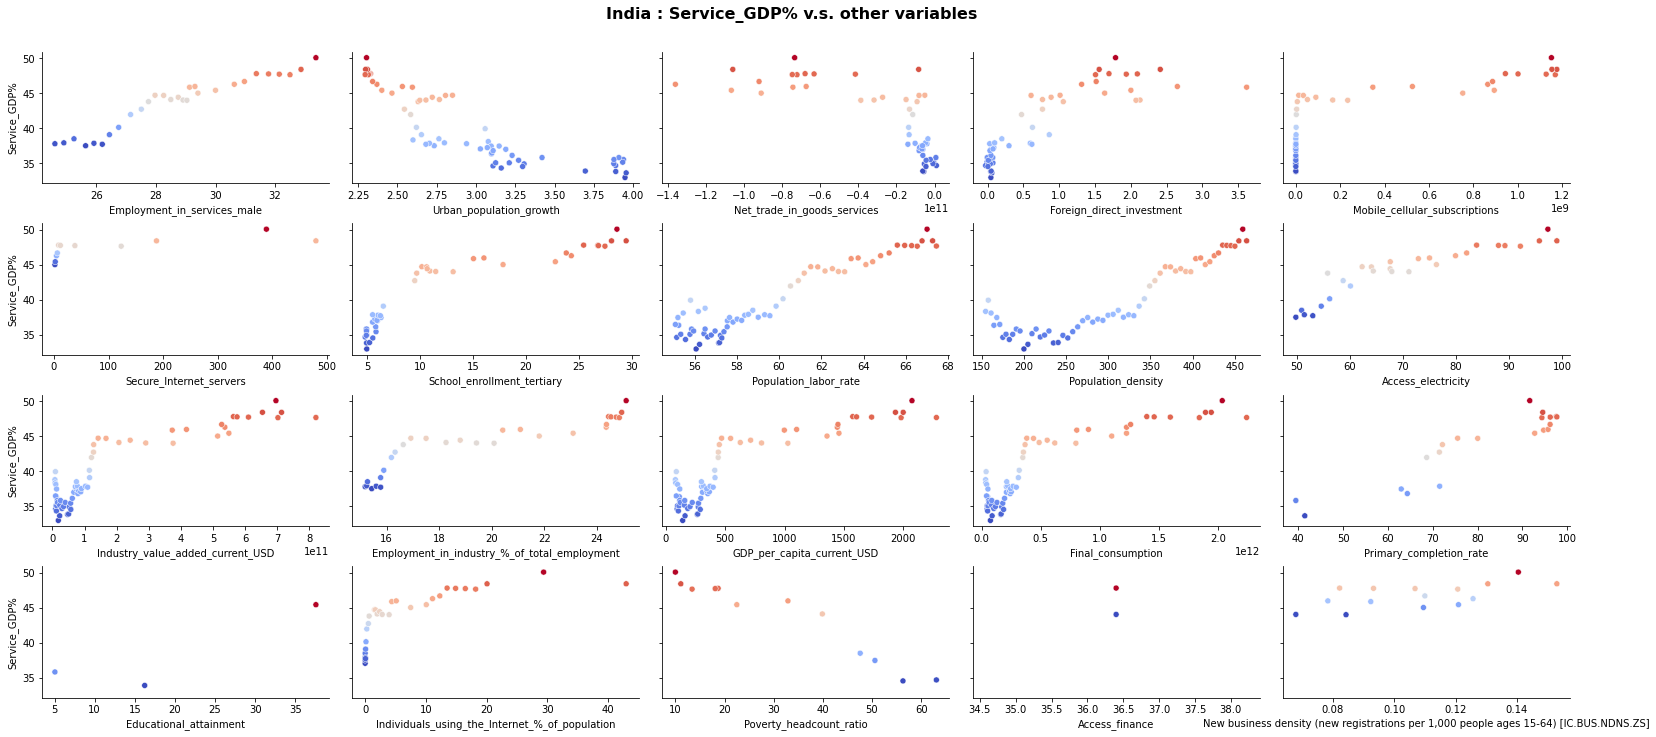

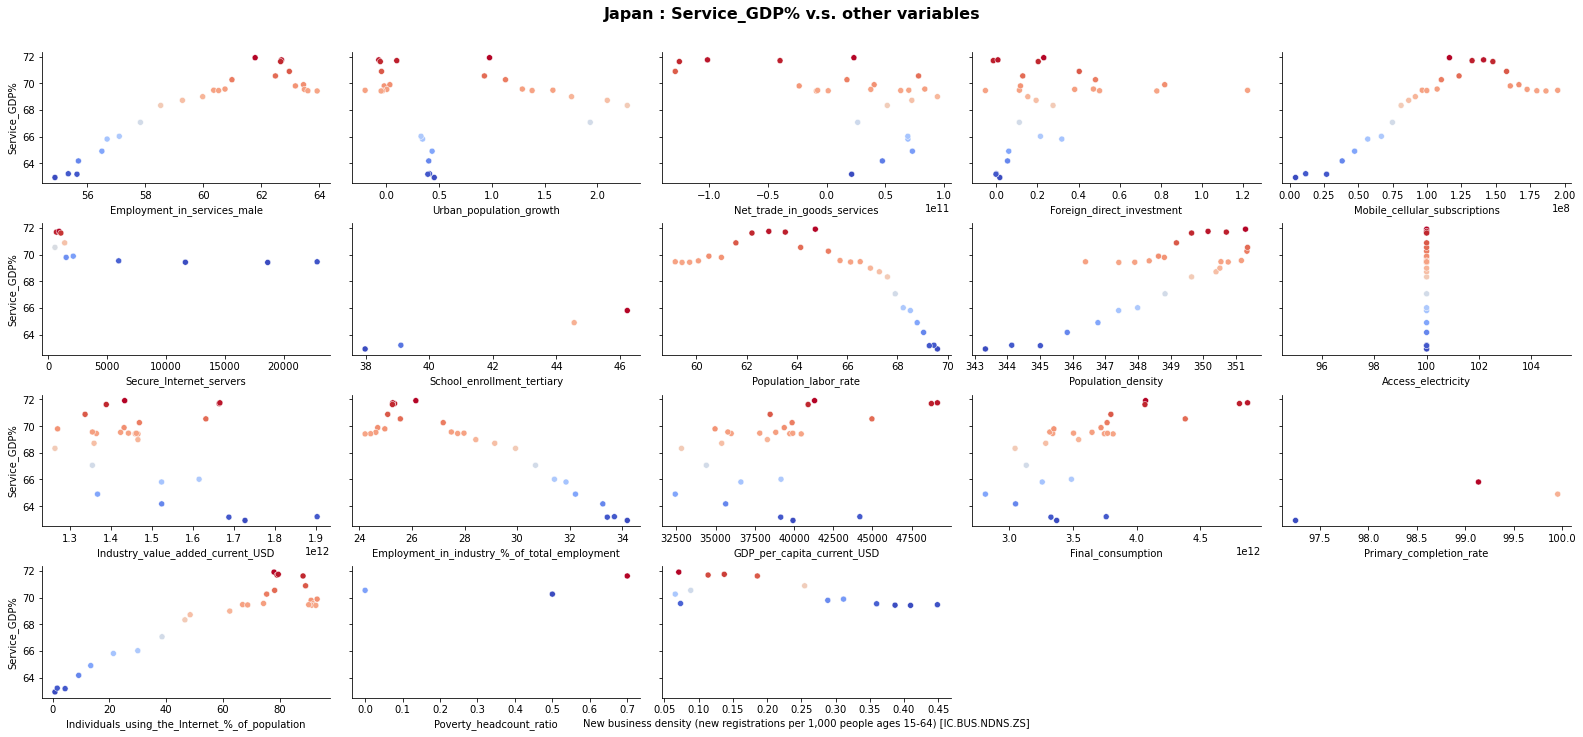

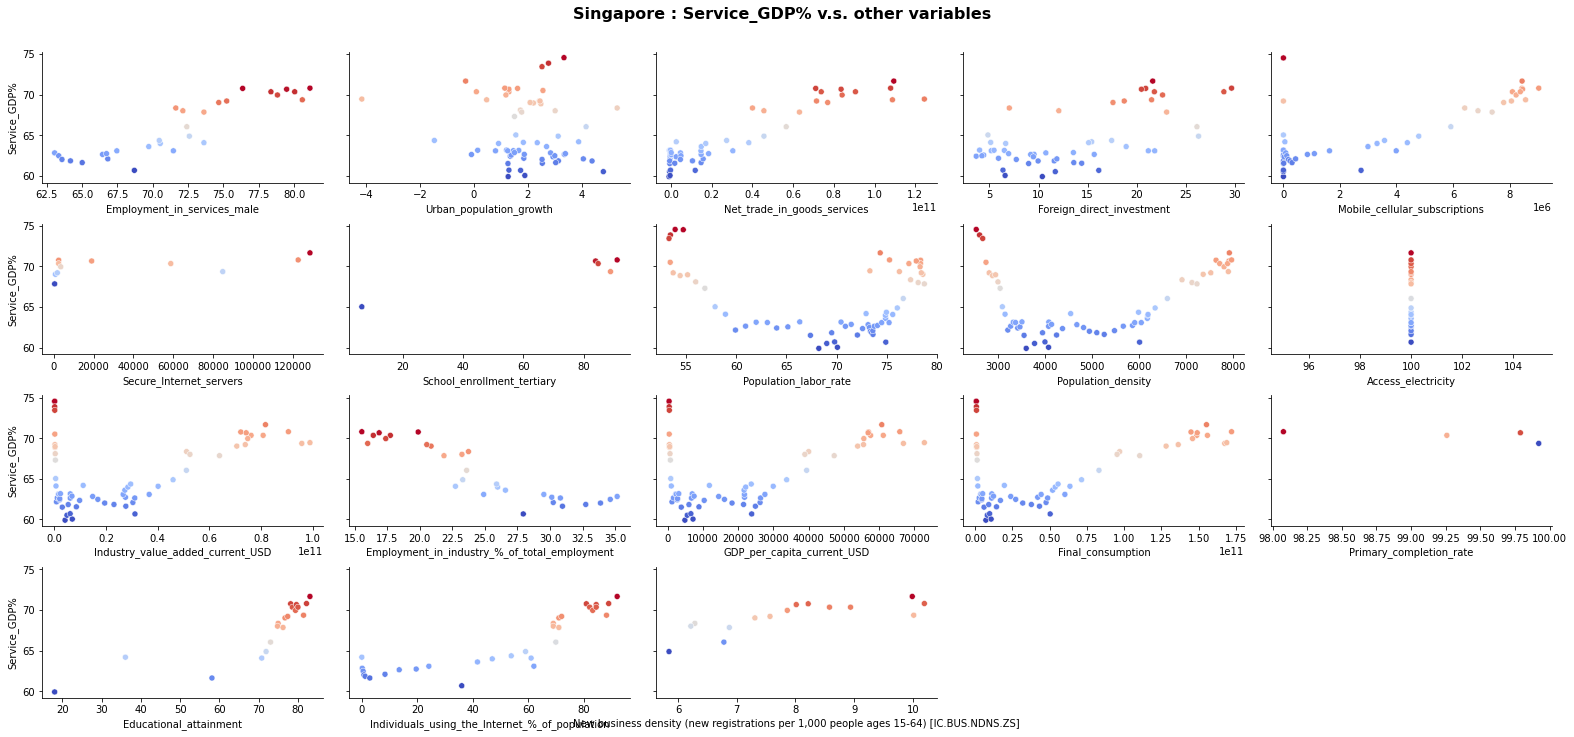

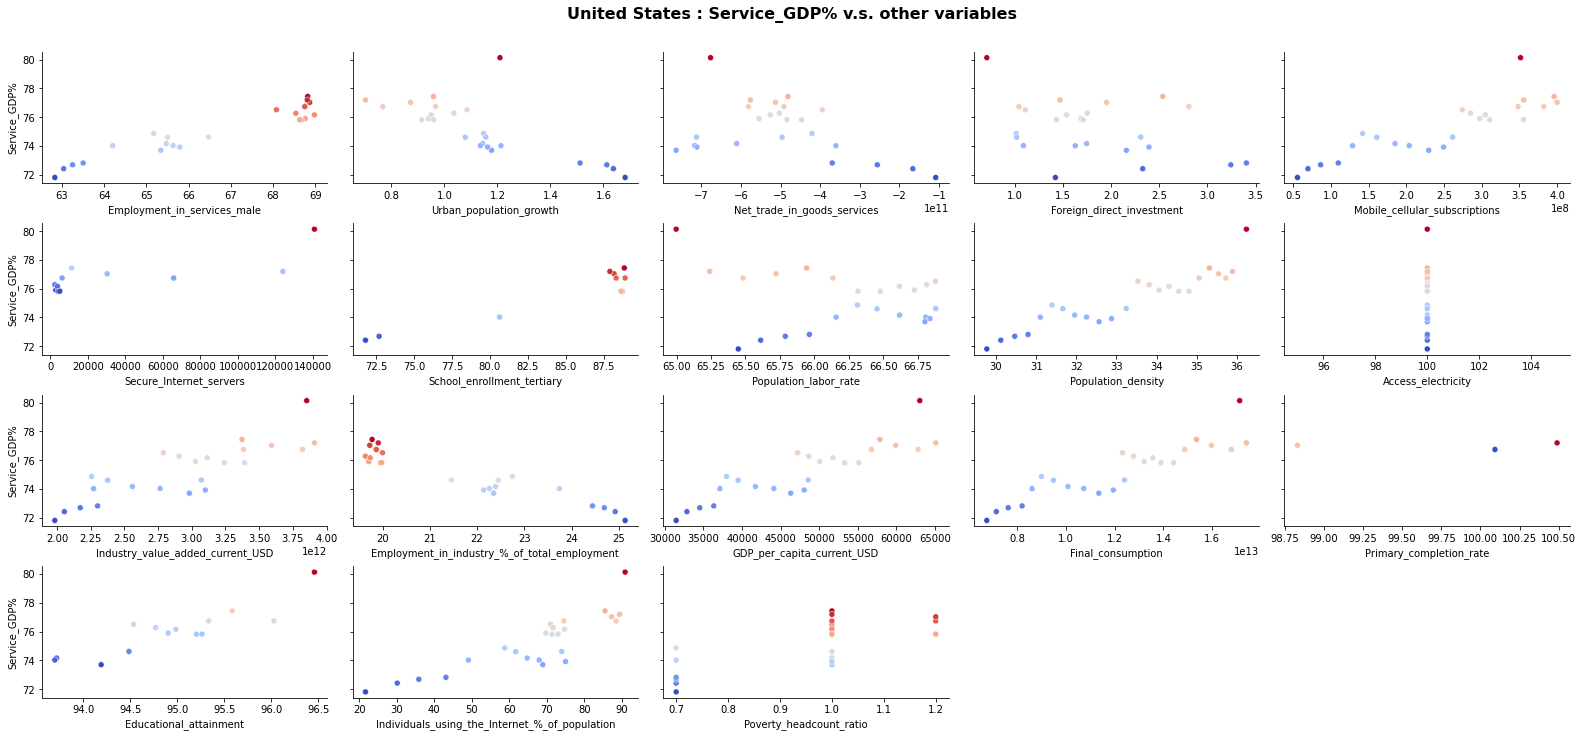

In [ ]:
for country in s_dfs.keys():
    make_pairwise_plot(country = country,df = s_dfs, name = 'Service_GDP%', num=5)

#### Correlation plot

In [12]:
import plotly.graph_objects as go

df = m_dfs['CHN']
df = df.drop('Access_finance', axis =1)
corr = df.replace('..', np.nan).corr()
cmap = sns.color_palette('coolwarm', 10).as_hex()[:]

fig = go.Figure(data=[go.Table(
    header=dict(values=['<b>Variables</b>', '<b>Manufacturing_value added_%_of_GDP%_of_GDP</b>'],
                line_color='darkslategray',
                fill_color='white',
                height=29,
                align=['left', 'center']),
    cells=dict(values=round(corr[['Manufacturing_value added_%_of_GDP']],4).reset_index().values[:-1,:].T,
               line_color='darkslategray',
               font=dict(color='black'),
               fill_color=[[cmap[1], cmap[2], cmap[0], cmap[0], cmap[-2], cmap[0], cmap[-1], cmap[2], cmap[0], cmap[0], cmap[2], cmap[0]]],
               height=33,
               align=['left', 'center'])),
])

fig.update_layout(width=700, height=800)
fig.show()

In [13]:
import plotly.graph_objects as go

target = 'Services_value_added_%_of_GDP'
df = s_dfs['CHN']
df = df.drop(['Access_finance', 'Educational_attainment'] , axis =1)
corr = df.replace('..', np.nan).corr()
corr = corr.drop([target], axis = 0)

argmin = corr[target].nsmallest(2)[-1]
argmax = corr[target].nlargest(3)[-1]
step = (argmax-argmin)/10
conditions = [(corr[target]<i) & (corr[target]>=i-step) for i in np.arange(argmin, argmax+step, step)]
conditions.insert(-1, (corr[target]>=argmax))
conditions.insert(0, (corr[target]<=argmin))
cmap = sns.color_palette('coolwarm',13).as_hex()[:]
colors = np.select(conditions, cmap)
colors[0] = '#c83836'
fig = go.Figure(data=[go.Table(
    header=dict(values=['<b>Variables</b>', '<b>	Services_value_added_%_of_GDP</b>'],
                line_color='darkslategray',
                fill_color='white',
                height=29,
                align=['left', 'center']),
    cells=dict(values=round(corr[['Services_value_added_%_of_GDP']],4).reset_index().values[:-1,:].T,
               line_color='darkslategray',
               font=dict(color='black'),
               fill_color=[colors],
               height=33,
               align=['left', 'center'])),
])

fig.update_layout(width=700, height=800)
fig.show()

### save new data

In [14]:
to_drop_m = ['Access_finance',  'High_technology_exports', 'Net_trade_in_goods_services', 'Railways_goods_trans_million_ton-km']
to_drop_s = ['Access_finance',  'Educational_attainment', 'Urban_population_growth']

In [27]:
with pd.ExcelWriter("cleaned/Manufacturing.xlsx") as writer:  
  for c in m_dfs.keys():
    subdata = m_dfs[c]
    subdata = subdata \
            .replace('..', np.nan) \
            .drop(to_drop_m, axis = 1)
    subdata = subdata[subdata[subdata.columns[-1]].notna()]
    subdata.to_excel(writer, sheet_name=c) 

In [29]:
with pd.ExcelWriter("cleaned/Service.xlsx") as writer2:  
  for c in s_dfs.keys():
    subdata = s_dfs[c]
    subdata = subdata \
            .replace('..', np.nan) \
            .drop(to_drop_s, axis = 1)
    subdata = subdata[subdata[subdata.columns[-1]].notna()]
    subdata.to_excel(writer2,sheet_name=c) 